# 0. Install important libraries

In [1]:
%%capture
# Install libraries
!pip install tensorflow keras pillow numpy tqdm underthesea gensim fasttext nltk

In [2]:
print("hello")

hello


In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Import important libraries

In [4]:
%%capture
import os
import sys
import string
import fasttext
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from pickle import dump, load
from underthesea import word_tokenize
from gensim.utils import simple_preprocess
from collections import defaultdict

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.sequence import pad_sequences

# from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, add
from keras.layers import Concatenate, Multiply, Lambda
from keras.initializers import Constant
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu

# 2. Getting and performing data cleaning

In [5]:
def load_doc(filename):
    file = open(filename, 'r', encoding='utf-8')
    text = file.read()
    file.close()
    
    return text

In [6]:
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = defaultdict()
    for caption in captions[:-1]:
        img, cap = caption.split('\t')
        if img not in descriptions:
            descriptions[img] = [cap]
        else:
            descriptions[img].append(cap)
    return descriptions

In [7]:
def cleaning_text(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for img, captions in descriptions.items():
        for idx, cap in enumerate(captions):
            desc = cap.replace(' - ', ' ').translate(table)
            desc = ' '.join(simple_preprocess(desc))
            desc = word_tokenize(desc, format='text')
            
            descriptions[img][idx] = desc
    return descriptions

In [8]:
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(desc.split()) for desc in descriptions[key]]
    
    return vocab

In [9]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, captions in descriptions.items():
        for cap in captions:
            lines.append(key + '\t' + cap)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding='utf-8')
    file.write(data)
    file.close()

In [10]:
dataset_text = '../input/flickr8k-vi-caps'
dataset_images = '../input/flickr8k/Images'
sample_image = '2423292784_166ee54e0b.jpg'

text_file = dataset_text + '/' + 'captions_vi.txt'

In [11]:
descriptions = all_img_captions(text_file)
print('Length of descriptions:', len(descriptions))
print('Description before clean text')
descriptions[sample_image]

Length of descriptions: 8000
Description before clean text


['Một cậu bé với một cái chao kim loại trên đầu ',
 ' Một chú hề nhỏ với chiếc chao trên đầu',
 ' Một cậu bé điên có một cái bát trên đầu',
 ' Một cậu bé đội một chiếc chao kim loại trên đầu',
 ' Cậu bé mặc áo sơ mi sọc này đang đặt một cái rây trên đầu']

In [12]:
clean_descriptions = cleaning_text(descriptions)
print('Descriptions after clean text')
clean_descriptions[sample_image]

Descriptions after clean text


['một cậu bé với một cái chao kim_loại trên đầu',
 'một chú hề nhỏ với chiếc chao trên đầu',
 'một cậu bé điên có một cái bát trên đầu',
 'một cậu bé đội một chiếc chao kim_loại trên đầu',
 'cậu bé mặc áo sơ_mi sọc này đang đặt một cái rây trên đầu']

In [13]:
vocab = text_vocabulary(clean_descriptions)
print('Length of vocabuary:', len(vocab))

Length of vocabuary: 5562


In [14]:
# save_descriptions(clean_descriptions, 'descriptions.txt')

# 3. Extract feature vector from all images

In [15]:
def extract_feature(directory):
    model = InceptionV3(weights='imagenet')
    model = Model(model.input, model.layers[-2].output)
    
    features = dict()
    for img in tqdm(os.listdir(directory), file=sys.stdout):
        filename = directory + '/' + img
        image = load_img(filename, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        
        feature = model.predict(image, verbose=0)
        features[img] = feature
    return features

In [16]:
# features = extract_feature(dataset_images)
# dump(features, open('features_inception_v3.pkl', 'wb'))

In [17]:
feature_path = '../input/flickr8k-feature-vector/features_inception_v3.pkl'
features = load(open(feature_path, 'rb'))

In [18]:
features[sample_image]

array([[0.10134819, 0.17562562, 0.00392631, ..., 0.91039944, 0.31022805,
        0.23347566]], dtype=float32)

# 4. Loading dataset for training the model

In [19]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split('\n')
    return photos

In [20]:
def load_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = defaultdict()
    for line in file.split('\n'):
        line = line.split('\t')
        
        if len(line) < 1:
            continue
            
        image, cap = line[0], line[1]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = list()
            desc = 'startseq ' + cap + ' endseq'
            descriptions[image].append(desc)
    return descriptions

In [21]:
def load_features(photos):
    all_features = load(open(feature_path, 'rb'))
    features = {img: all_features[img] for img in photos}
    return features

In [22]:
train_imgs = load_photos(dataset_text + '/' + 'trainImages.txt')
train_descriptions = load_descriptions('../input/filck8khoangchi/descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

test_imgs = load_photos(dataset_text + '/' + 'testImages.txt')
test_descriptions = load_descriptions('../input/filck8khoangchi/descriptions.txt', test_imgs)
test_features = load_features(test_imgs)

# 5. Tokenizing the vocabulary and word embedding

In [23]:
def dict_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [24]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    oov_token = 'unk'
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)
# dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('# vocabulary:', vocab_size)

In [ ]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(desc.split()) for desc in desc_list)
max_length = max_length(descriptions)
print('Max length of train set:', max_length)

In [27]:
def create_embedding_matrix(vocab):
    embedding_index = fasttext.load_model('../input/fasttext-vietnamese-word-vectors-full/cc.vi.300.bin')
    
    embedding_dim = 300
    hits = 0
    misses = 0
    vocab_size = len(vocab) + 1
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    
    return embedding_matrix

In [28]:
%%capture --no-stdout
vocab = tokenizer.word_index
embedding_matrix = create_embedding_matrix(vocab)
print(embedding_matrix.shape)

Converted 3298 words (0 misses)
(3299, 300)


# 6. Create data generator

In [29]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    
    while True:
        for key, captions in descriptions.items():
            n += 1
            feature = features[key][0]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [30]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length, vocab_size, 32))
a.shape, b.shape, c.shape

((2356, 2048), (2356, 41), (2356, 3299))

# 7. Defining the CNN-RNN model

In [31]:
from keras.layers.core import Flatten
import keras.backend as K
from keras.layers import Multiply, Lambda, Flatten, RepeatVector, GlobalMaxPooling1D
def define_model(vocab_size, max_length):
    embedding_dim = 300
    lstm_size = 256

    # Define inputs
    inputs1 = Input(shape=(2048,))
    inputs2 = Input(shape=(max_length,))

    # Image feature extraction
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(lstm_size, activation='relu')(fe1)

    # Text feature extraction
    se1 = Embedding(
        vocab_size,
        embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),
        mask_zero=True,
        trainable=False,
    )(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = Bidirectional(LSTM(128, return_sequences=True))(se2)

    # Attention mechanism
    features = Dense(lstm_size)(fe2)
    attention_dense = Dense(lstm_size, activation='tanh')
    attention_softmax = Dense(1, activation='softmax')
    attention = attention_softmax(attention_dense(se3))
    attention = Multiply()([features, attention])
    context = Lambda(lambda x: K.sum(x, axis=1))(attention)
    context = RepeatVector(max_length)(context)


    # Merge the image features and attention context with LSTM output
    merged = add([se3, context])
    decoder2 = Dropout(0.5)(merged)
    decoder3 = LSTM(lstm_size)(decoder2)
    outputs = Dense(vocab_size, activation='softmax')(decoder3)

    # Define and compile the model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

#     decoder1 = add([fe2, dropout_layer])
#     decoder2 = Dense(256, activation='relu')(decoder1)
#     outputs = Dense(vocab_size, activation='softmax')(decoder2)

#     model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001))

    print(model.summary())
#     plot_model(model, to_file='model.png', show_shapes=True)

    return model

# 8. Training the model

In [32]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 100
batch_size = 32
steps = len(train_imgs) // batch_size

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 3299
Description Length:  41
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 41)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 41, 300)      989700      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 41, 300)      0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                

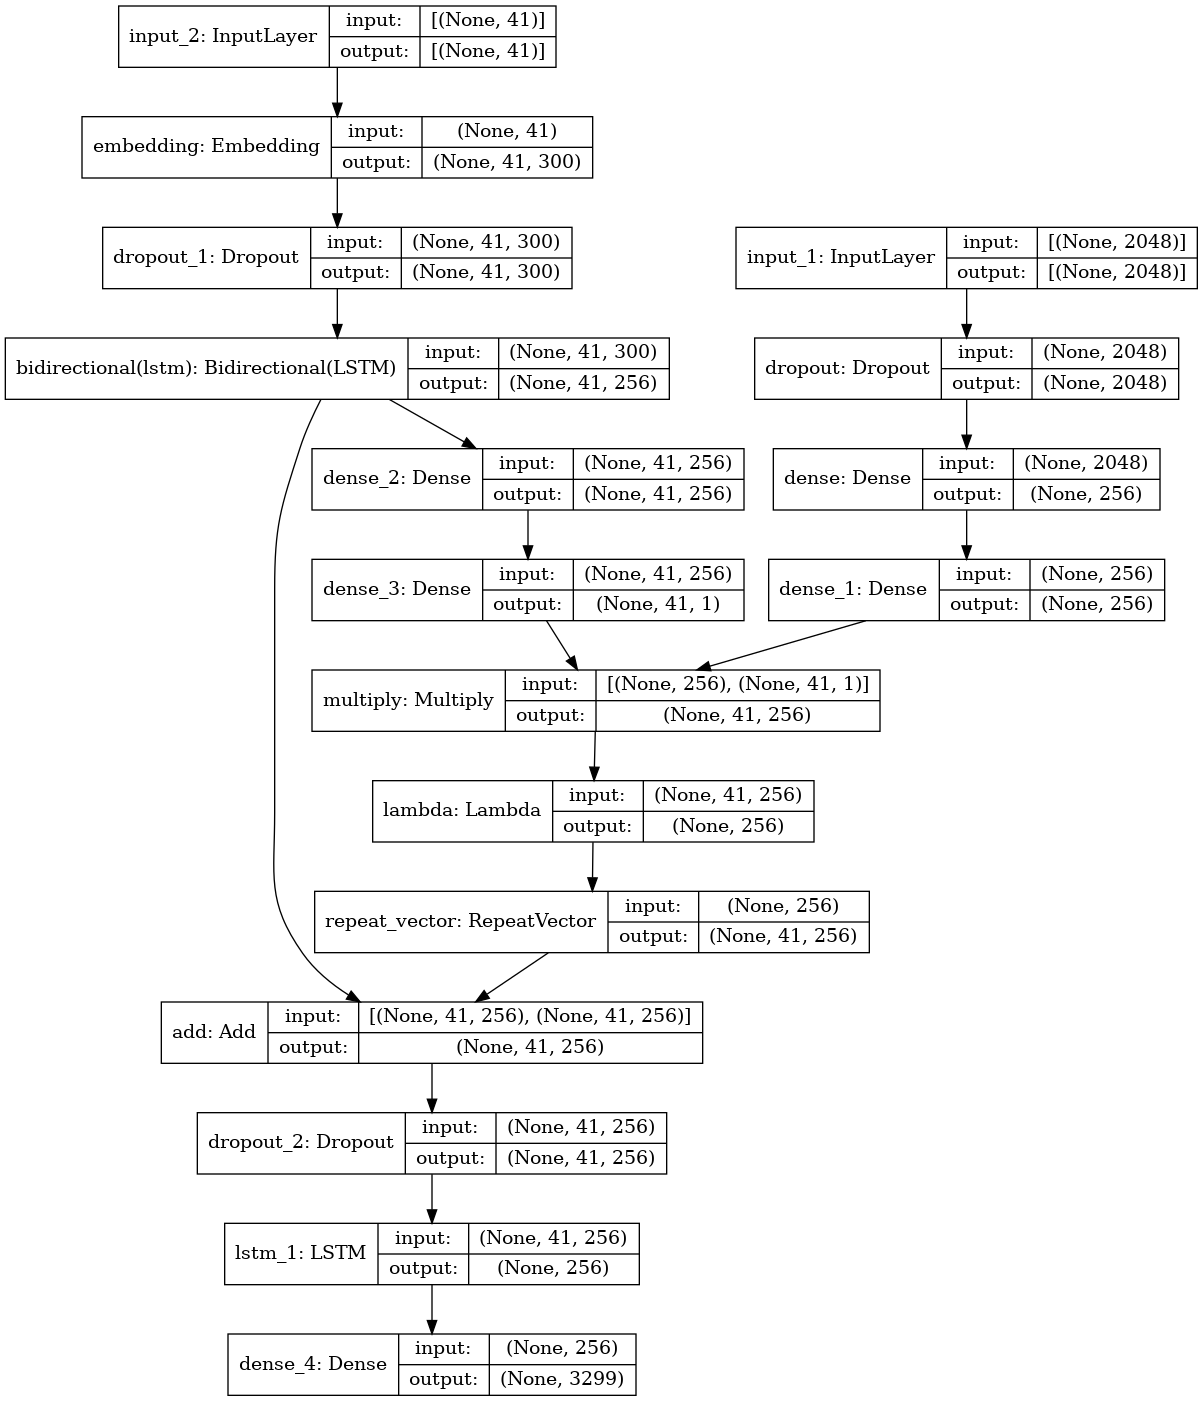

In [33]:
# Plot the model
plot_model(model, to_file="model.png", show_shapes=True)

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



187/187 [==============================] - 110s 587ms/step - loss: 4.7409


In [ ]:
model.save("best_model_attention.h5")

In [ ]:
# Load model
model.load_weights("best_model_attention.h5")

# 9. Generate captions for the image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([image, seq], verbose=0)
        pred_ids = np.argmax(yhat)
        word = idx_to_word(pred_ids, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        
    return in_text

In [ ]:
model = load_model('best_model_attention.h5')
actual, predicted = list(), list()

for image in tqdm(test_imgs):
    captions = test_descriptions[image]
    actual_captions = [caption.split() for caption in captions]

    y_pred = predict_caption(model, test_features[image], tokenizer, max_length)
    y_pred = y_pred.split()

    actual.append(actual_captions)
    predicted.append(y_pred)

# BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# 10. Visualize the results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_path = os.path.join(dataset_images, image_name)
    image = Image.open(image_path)
    descriptions = load_descriptions('descriptions.txt', train_imgs + test_imgs)
    captions = descriptions[image_name]
    print('-' * 20 + 'Actual' + '-' * 20)
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('-' * 20 + 'Predicted' + '-' * 20)
    print(y_pred)
    plt.imshow(image)

In [ ]:
from random import sample

image_name = sample(train_imgs, 1)[0]
print(image_name)
generate_caption(image_name)

In [ ]:
# Save model
# model.save("best_model.h5")

In [ ]:
# Load model
# from tensorflow.keras.models import load_model
# model.load_weights("../input/filck8khoangchi/best_model.h5")